In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

from sklearn.cluster import KMeans
import napari

from image_analysis.read_files import get_paths, change_paths
from image_analysis.fit import plot, roi, regionprops
from image_analysis.preprocess import mask

In [3]:
pixel_size = 2

In [4]:
pc = 50

In [5]:
folder_pretreated = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'
df = pd.read_excel("results/system_size_L_and_gaps_x0_L3d_x0_proj.xlsx")

In [6]:
df = df[df['Animal size, cm'] == 'development']

In [7]:
df.head()

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm","Average animal size inside each group, cm",Unnamed: 6,Unnamed: 7,system_size_L_along_SF_pc50_um,length_L_SF_pc50_um,x0_pc50_um_shh,x0_pc50_um_fgf,PD_length_50_um
0,hcr11_lb27_fl,11,development,development,1.5,NaN,NaN,NaN,284,174,40,120,144
1,hcr11_lb28_fl,11,development,development,1.5,NaN,NaN,NaN,300,158,50,106,168
2,hcr15_lb41_fl,15,development,development,1.5,NaN,NaN,NaN,250,156,30,54,186
3,hcr16_lb44_fl,16,development,development,1.5,NaN,NaN,NaN,240,118,50,60,168
4,hcr16_lb45_fl,16,development,development,1.5,NaN,NaN,NaN,256,132,48,88,118


# Find plane to show: plane trough SF closest to p1p2

In [8]:
ex = np.array([0,0,1])
ey = np.array([0,-1,0])
ez = np.cross(ex, ey)

In [9]:
i = 13
file_name = df['Sample name'].values[i]
    
file = os.path.join( folder_pretreated, file_name) + '.npy'

keys = np.load( file.split('.npy')[0] + '_keys.npy' )
image = dict(zip(
    keys,
    np.load( file )
))

    
image = dict(zip(
    ['shh_mask', 'fgf_mask', 'tissue_mask_with_epi'],
    [ (image[f'shh{pc}_clip'] > 0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
))

image['shh_mask'] = mask.largest_component( image['shh_mask'] )
image['fgf_mask'] = mask.largest_component( image['fgf_mask'] )
 
regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
regionprops_3d.tensor_inertia('tissue_mask_with_epi')

SF = np.array( regionprops_3d.parm['cm_fgf_mask'] - regionprops_3d.parm['cm_shh_mask'] )

i = 0
p0 = (1/regionprops_3d.parm['lams_tissue_mask_with_epi'][i])*regionprops_3d.parm['v_tissue_mask_with_epi'][i]

N_desired = regionprops.compute_N_desired(p0, SF)

/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)


In [10]:
scale_u = (pixel_size, pixel_size, pixel_size)
viewer = napari.Viewer()
viewer.add_image(image['tissue_mask_with_epi'], name='tissue_mask_with_epi', scale=scale_u)
viewer.add_image(image['shh_mask'], name='shh_mask', gamma=0.2, opacity=0.5, colormap="red", scale=scale_u)
viewer.add_image(image['fgf_mask'], name='fgf_mask', gamma=0.2, opacity=0.5, colormap="blue", scale=scale_u)

viewer.axes.visible = True
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

viewer.add_points(regionprops_3d.parm['cm_shh_mask'], name='cm_shh', face_color='red')
viewer.add_points(regionprops_3d.parm['cm_fgf_mask'], name='cm_fgf', face_color='blue')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_fgf_mask'] ])
viewer.add_shapes(vector_line, shape_type='line', name='SF', edge_color='red')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 10*N_desired ])
viewer.add_shapes(vector_line, shape_type='line', name='normal to plane through SF closest to p1p2', edge_color='black')

for i in range(0, 3):
    vector_line = np.array([regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask']+(1e5/regionprops_3d.parm['lams_tissue_mask_with_epi'][i])*regionprops_3d.parm['v_tissue_mask_with_epi'][i]])
    viewer.add_shapes(vector_line, shape_type='line', name='PCAtissue_mask_with_epi'+str(i), edge_color='green')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ex ])
viewer.add_shapes(vector_line, shape_type='line', name='ex', edge_color='red')
vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ey ])
viewer.add_shapes(vector_line, shape_type='line', name='ey', edge_color='green')
vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ez ])
viewer.add_shapes(vector_line, shape_type='line', name='ez', edge_color='blue')

<Shapes layer 'ez' at 0x75bb9c3ca520>

# Check rotations in 3d

In [11]:
image = regionprops_3d.rotate_N_desired_to_ez_special()

regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
regionprops_3d.tensor_inertia('tissue_mask_with_epi')

SF = np.array( regionprops_3d.parm['cm_fgf_mask'] - regionprops_3d.parm['cm_shh_mask'] )
p0 = (1/regionprops_3d.parm['lams_tissue_mask_with_epi'][0])*regionprops_3d.parm['v_tissue_mask_with_epi'][0]
N_desired = regionprops.compute_N_desired(p0, SF)

/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/D

Strange rotation, RETURN NOT ROTATED
Angle between ez and N_desired: 55


In [12]:
scale_u = (pixel_size, pixel_size, pixel_size)
viewer = napari.Viewer()
viewer.add_image(image['tissue_mask_with_epi'], name='tissue_mask_with_epi', scale=scale_u)
viewer.add_image(image['shh_mask'], name='shh_mask', gamma=0.2, opacity=0.5, colormap="red", scale=scale_u)
viewer.add_image(image['fgf_mask'], name='fgf_mask', gamma=0.2, opacity=0.5, colormap="blue", scale=scale_u)

viewer.axes.visible = True
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

viewer.add_points(regionprops_3d.parm['cm_shh_mask'], name='cm_shh', face_color='red')
viewer.add_points(regionprops_3d.parm['cm_fgf_mask'], name='cm_fgf', face_color='blue')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_fgf_mask'] ])
viewer.add_shapes(vector_line, shape_type='line', name='SF', edge_color='gray')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 10*N_desired ])
viewer.add_shapes(vector_line, shape_type='line', name='normal to plane through SF closest to p1p2', edge_color='black')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ex ])
viewer.add_shapes(vector_line, shape_type='line', name='ex', edge_color='red')
vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ey ])
viewer.add_shapes(vector_line, shape_type='line', name='ey', edge_color='green')
vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ez ])
viewer.add_shapes(vector_line, shape_type='line', name='ez', edge_color='blue')

<Shapes layer 'ez' at 0x75bb77fff820>

# Cluster limb buds based on size

In [13]:
df.head()

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm","Average animal size inside each group, cm",Unnamed: 6,Unnamed: 7,system_size_L_along_SF_pc50_um,length_L_SF_pc50_um,x0_pc50_um_shh,x0_pc50_um_fgf,PD_length_50_um
0,hcr11_lb27_fl,11,development,development,1.5,NaN,NaN,NaN,284,174,40,120,144
1,hcr11_lb28_fl,11,development,development,1.5,NaN,NaN,NaN,300,158,50,106,168
2,hcr15_lb41_fl,15,development,development,1.5,NaN,NaN,NaN,250,156,30,54,186
3,hcr16_lb44_fl,16,development,development,1.5,NaN,NaN,NaN,240,118,50,60,168
4,hcr16_lb45_fl,16,development,development,1.5,NaN,NaN,NaN,256,132,48,88,118


In [14]:
df = df.sort_values(by=f'PD_length_{pc}_um', ascending=True)
df = df.reset_index(drop=True)

In [15]:
# Number of clusters (n_clusters)
n_clusters = 3

# KMeans clustering for group assignment
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df = df.copy()  # Ensure it's not a view
df['Size_Group'] = kmeans.fit_predict(df[[f'PD_length_{pc}_um']])

# Labels to increase mean value
group_means = df.groupby('Size_Group')[f'PD_length_{pc}_um'].mean()

# Sort groups by their mean values and reassign group labels
sorted_groups = group_means.sort_values().index
group_mapping = {old: new for new, old in enumerate(sorted_groups)}
df['Size_Group'] = df['Size_Group'].map(group_mapping)

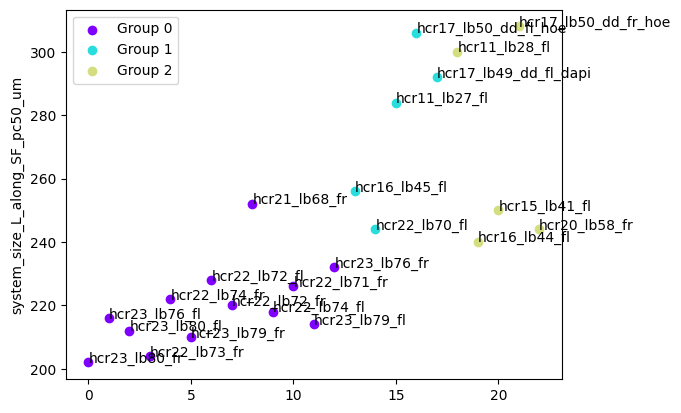

In [16]:
colors = plt.cm.rainbow([i / n_clusters for i in range(n_clusters)])
color_map = {i: colors[i] for i in range(n_clusters)}

for idx, row in df.iterrows():
    plt.scatter(
        idx,  
        row[f'system_size_L_along_SF_pc{pc}_um'],  
        color=color_map[row['Size_Group']]
    )
    # Add text label for each sample
    plt.text(
        idx,
        row[f'system_size_L_along_SF_pc{pc}_um'],
        row['Sample name']
    )

# Add legend
for group, color in color_map.items():
    plt.scatter([], [], color=color, label=f'Group {group}')

plt.ylabel(f'system_size_L_along_SF_pc{pc}_um')
plt.legend()
plt.show()

In [17]:
keys_dpa = set( [str(h) for h in df['Size_Group'].values] )
keys_dpa

{'0', '1', '2'}

# Orient all

In [18]:
img = dict.fromkeys(keys_dpa, 0)

for tkey in keys_dpa:
    
    df_t  = df[df['Size_Group'] == int(tkey)]
    df_t  = df_t.reset_index(drop=True)
    nkeys = [str(i+1) for i in range(0, len(df_t))]
    img[tkey]  = dict.fromkeys(nkeys, 0)

    for index, row in df_t.iterrows():
        
        print(row['Sample name'])
        
        path = row['Sample name']
        keys = np.load( os.path.join(folder_pretreated, path + '_keys.npy') )
        
        image = dict(
            zip(
                keys, 
                np.load( os.path.join(folder_pretreated, path + '.npy') )
            )
        )

        if f'dusp{pc}_clip' in keys:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  (image[f'dusp{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))
        else:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  0*(image[f'shh{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))  
        
        image['shh_mask'] = mask.largest_component( image['shh_mask'] )
        image['dusp_mask'] = mask.largest_component( image['dusp_mask'] )
        image['fgf_mask'] = mask.largest_component( image['fgf_mask'] )
        # align

        regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
        regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
        regionprops_3d.tensor_inertia('tissue_mask_with_epi')

        if row['Sample name'] not in ['hcr21_lb68_fr']:
            image = regionprops_3d.rotate_N_desired_to_ez()
        else:
            image = regionprops_3d.rotate_N_desired_to_ez_special()
            
        regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
        
        
        S = regionprops.center_mass( image['shh_mask'] )
        F = regionprops.center_mass( image['shh_mask'] )

        print(S[0], F[0])
        
        # z-slice
        for key in image.keys():
            image[key] = image[key][S[0], :, :]
            
            if 'mask' in key:
                image[key] = (image[key] > 0) * 1
        img[tkey][str(index+1)] = dict(zip([path], [image]))

hcr11_lb28_fl


/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)


Angle between ez and N_desired: -5
95 95
hcr16_lb44_fl
Angle between ez and N_desired: -2
31 31
hcr15_lb41_fl
Angle between ez and N_desired: 1
28 28
hcr17_lb50_dd_fr_hoe
Angle between ez and N_desired: 3
45 45
hcr20_lb58_fr
Angle between ez and N_desired: 5
35 35
hcr23_lb80_fr
Angle between ez and N_desired: 6
41 41
hcr23_lb76_fl
Angle between ez and N_desired: -5
81 81
hcr23_lb80_fl
Angle between ez and N_desired: -5
52 52
hcr22_lb73_fr
Angle between ez and N_desired: 3
47 47
hcr22_lb74_fr
Angle between ez and N_desired: -1
53 53
hcr23_lb79_fr
Angle between ez and N_desired: 2
53 53
hcr22_lb72_fl
Angle between ez and N_desired: -3
50 50
hcr22_lb72_fr
Angle between ez and N_desired: 6
32 32
hcr21_lb68_fr
Angle between ez and N_desired: -8
99 99
hcr22_lb74_fl
Angle between ez and N_desired: 1
34 34
hcr22_lb71_fr
Angle between ez and N_desired: -21
Re-running the rotation function due to insufficient alignment
Angle between ez and N_desired: 23
Re-running the rotation function due to in

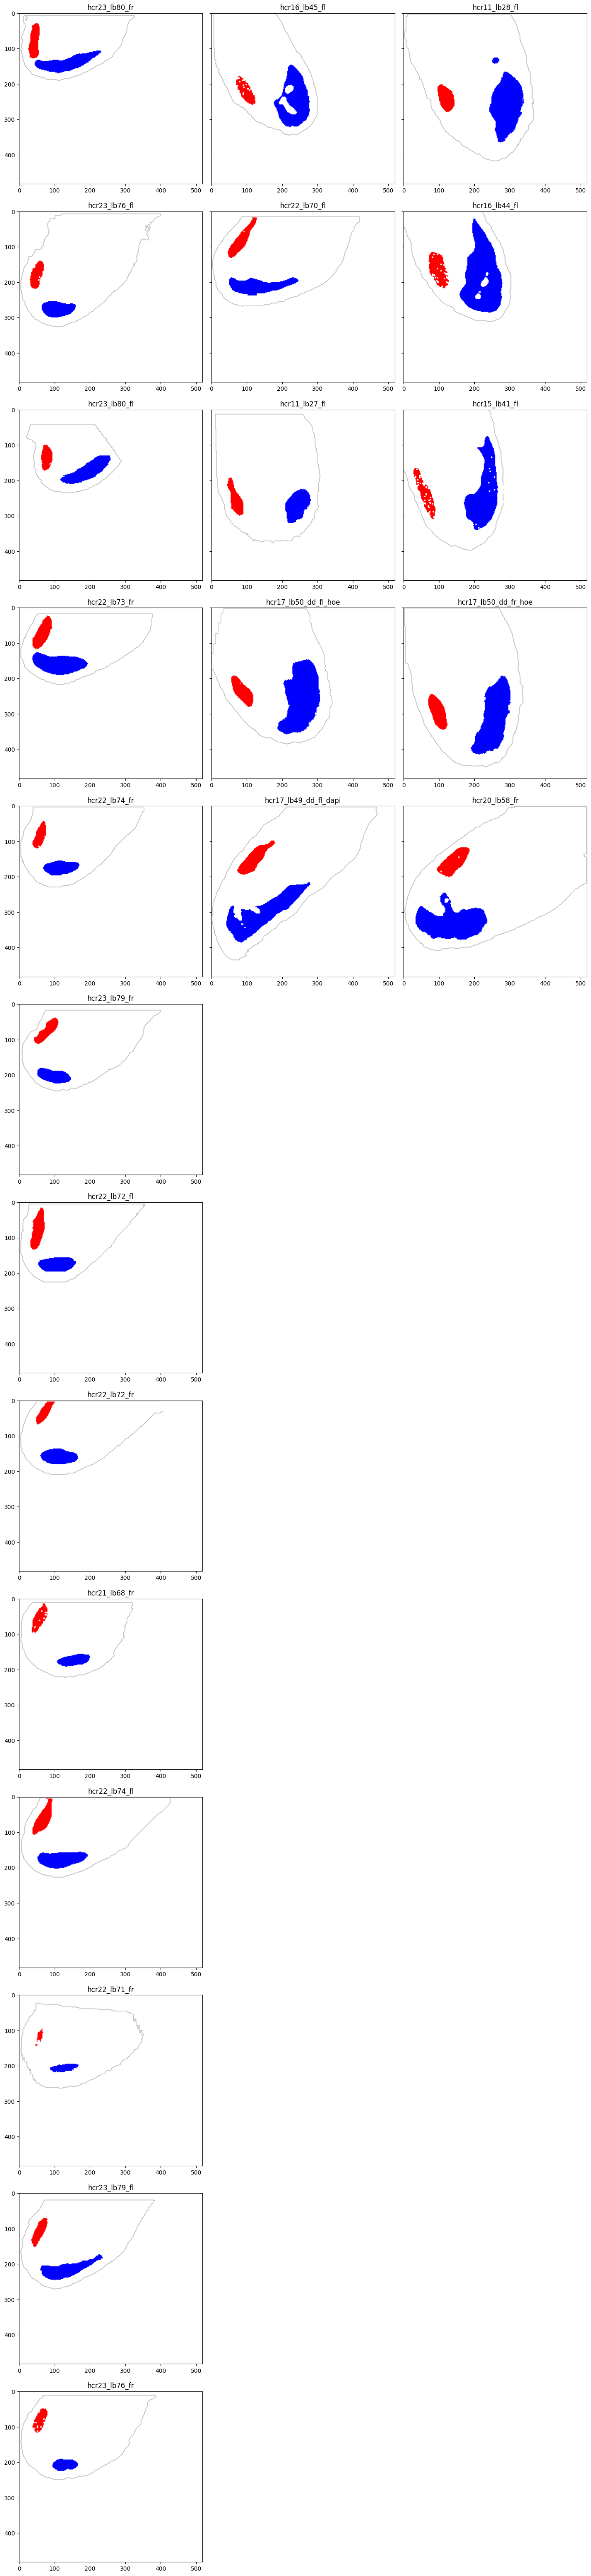

In [19]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh_mask', 'fgf_mask', 100)
#plt.savefig('fig/limb_buds_sorted_to_3_groups_based_on_size.pdf')
plt.show()

# Orient SF horizontally

In [20]:
ex_2d = np.array([0,1])

In [21]:
for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file in img[tkey][nkey].keys():

            #img[tkey][nkey][file]['shh_mask'] = img[tkey][nkey][file]['shh_mask'] * mask.largest_component( img[tkey][nkey][file]['shh_mask'] > 0 )
            #img[tkey][nkey][file]['fgf_mask'] = img[tkey][nkey][file]['fgf_mask'] * mask.largest_component( img[tkey][nkey][file]['fgf_mask'] > 0 )
        
            S = regionprops.center_mass(img[tkey][nkey][file]['shh_mask'])
            F = regionprops.center_mass(img[tkey][nkey][file]['fgf_mask'])
            
            SF   = F - S
            
            rot_x = 0
            rot_y = 0
            rot_z = roi.angle_between_2d(
                    SF, 
                    ex_2d
                )      
            #print(rot_z)
            
            img[tkey][nkey][file] = roi.rotate(img[tkey][nkey][file], rot_x, rot_y, rot_z)
            #img[tkey][nkey][file] = roi.flip(img[key_t][key_n], 1)

/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:37: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(img_arr, axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:40: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(img_arr, axis=1)


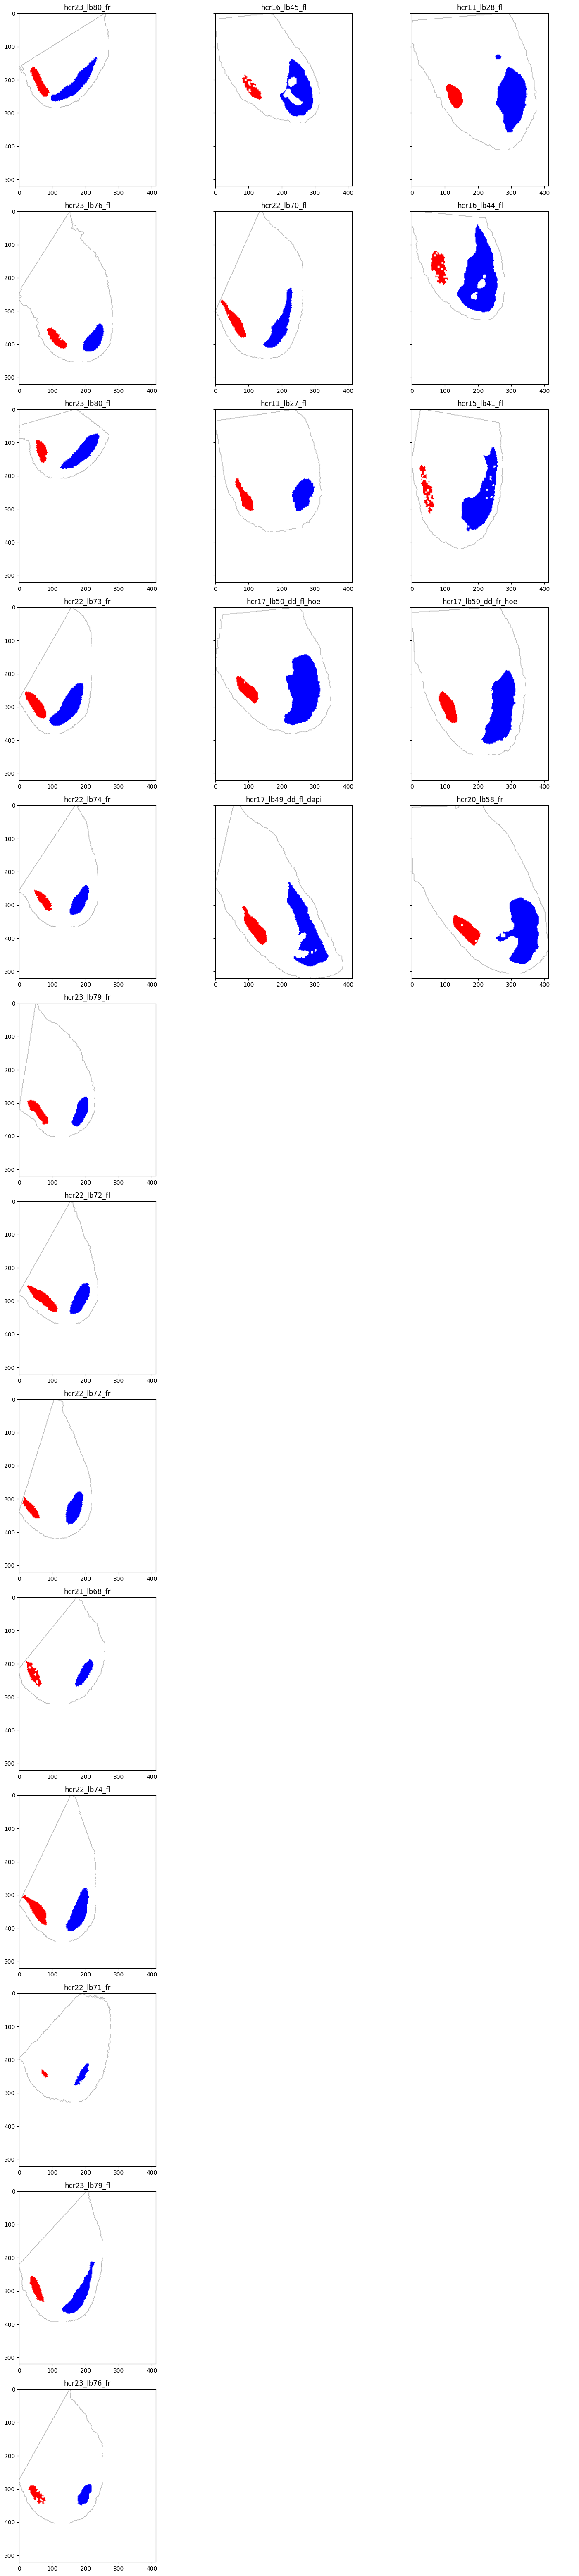

In [22]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh_mask', 'fgf_mask', 100)
#plt.savefig('fig/limb_buds_sorted_to_3_groups_based_on_size.pdf')
plt.show()

In [23]:
img.keys()

dict_keys(['2', '0', '1'])

In [24]:
img['2']['6'] = img['1']['5']
del img['1']['5']

In [25]:
import copy

to_copy = copy.deepcopy( img['0'] ['2'] )
img['0']['2'] = copy.deepcopy( img['1']['2'] )
img['1']['2'] = to_copy

# Make all images the same size 3200 : 3200

In [26]:
size = 1000

In [27]:
for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file in img[tkey][nkey].keys():
            
            # expand
            j, i = img[tkey][nkey][file]['shh_mask'].shape        
            for mkey in img[tkey][nkey][file].keys():
                arr = np.zeros( [size, size] ) 
                arr[0:j, 0:i] = img[tkey][nkey][file][mkey]
                img[tkey][nkey][file][mkey] = arr

            # shift
            S = regionprops.center_mass(img[tkey][nkey][file]['shh_mask'])
            F = regionprops.center_mass(img[tkey][nkey][file]['fgf_mask'])
            
            SF_middle = (S + F)/2
            
            for mkey in img[tkey][nkey][file].keys():
                shift_0 = int( size/2 -  SF_middle[0] )
                img[tkey][nkey][file][mkey] = np.roll(img[tkey][nkey][file][mkey], shift_0, 0)  
                
                shift_1 = int( size/2 - SF_middle[1] )
                img[tkey][nkey][file][mkey] = np.roll(img[tkey][nkey][file][mkey], shift_1, 1)            

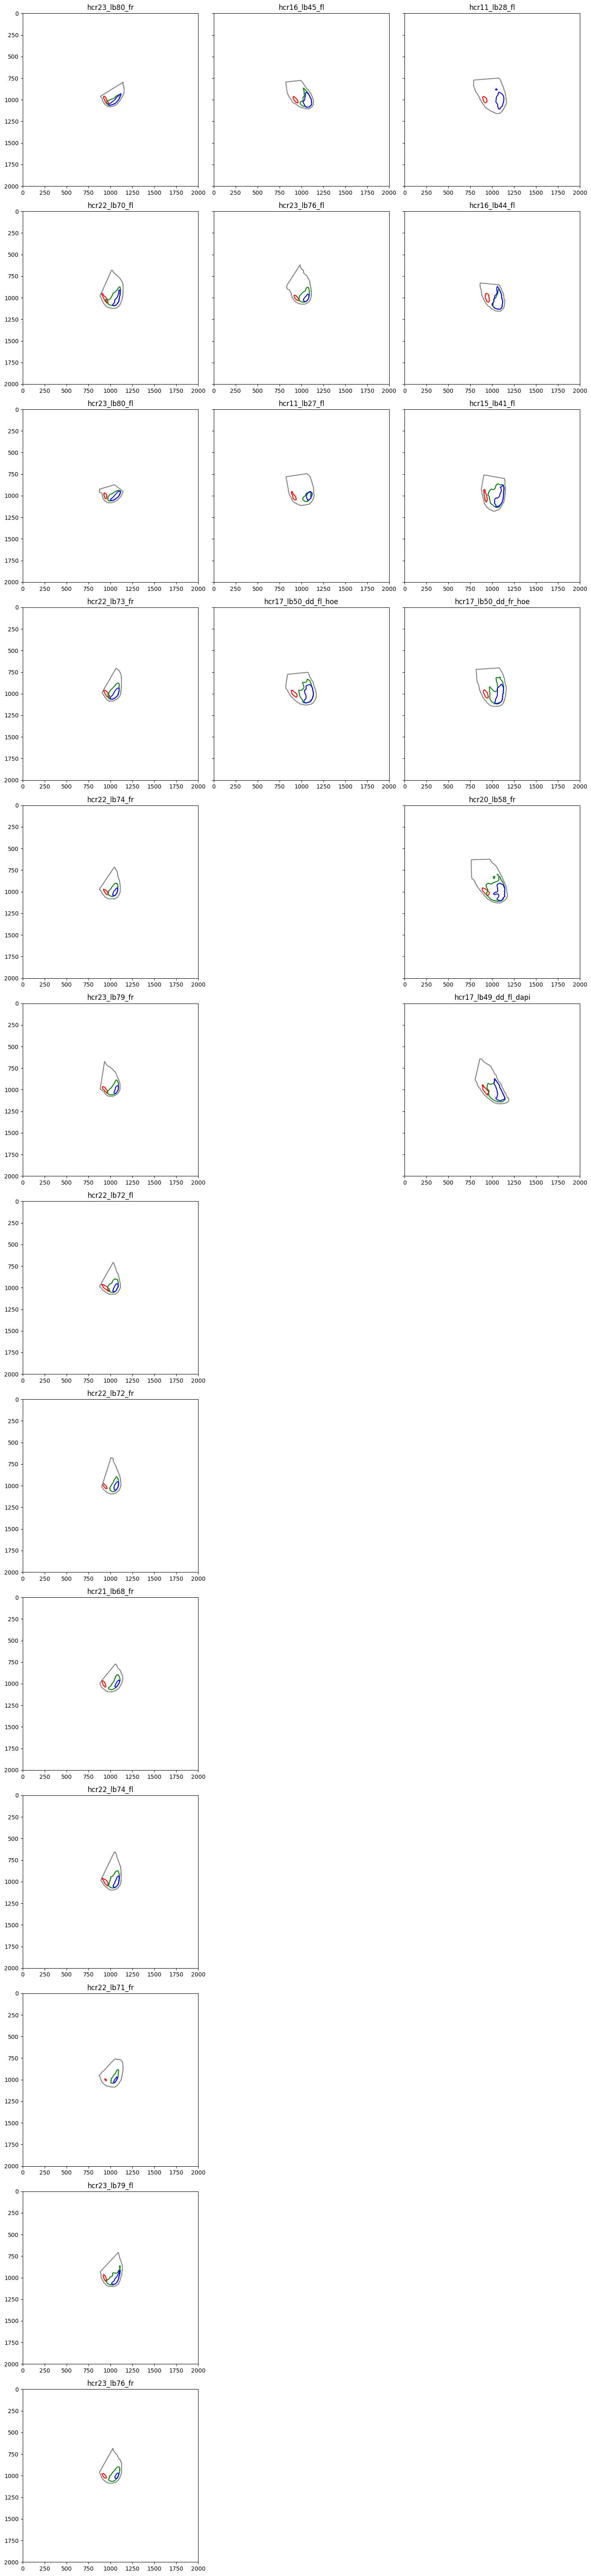

In [28]:
plot.shh_dusp_fgf_rgb(img, pixel_size, 'shh_mask', 'dusp_mask', 'fgf_mask', 100)
#plt.savefig('fig/limb_buds.pdf')
plt.show()

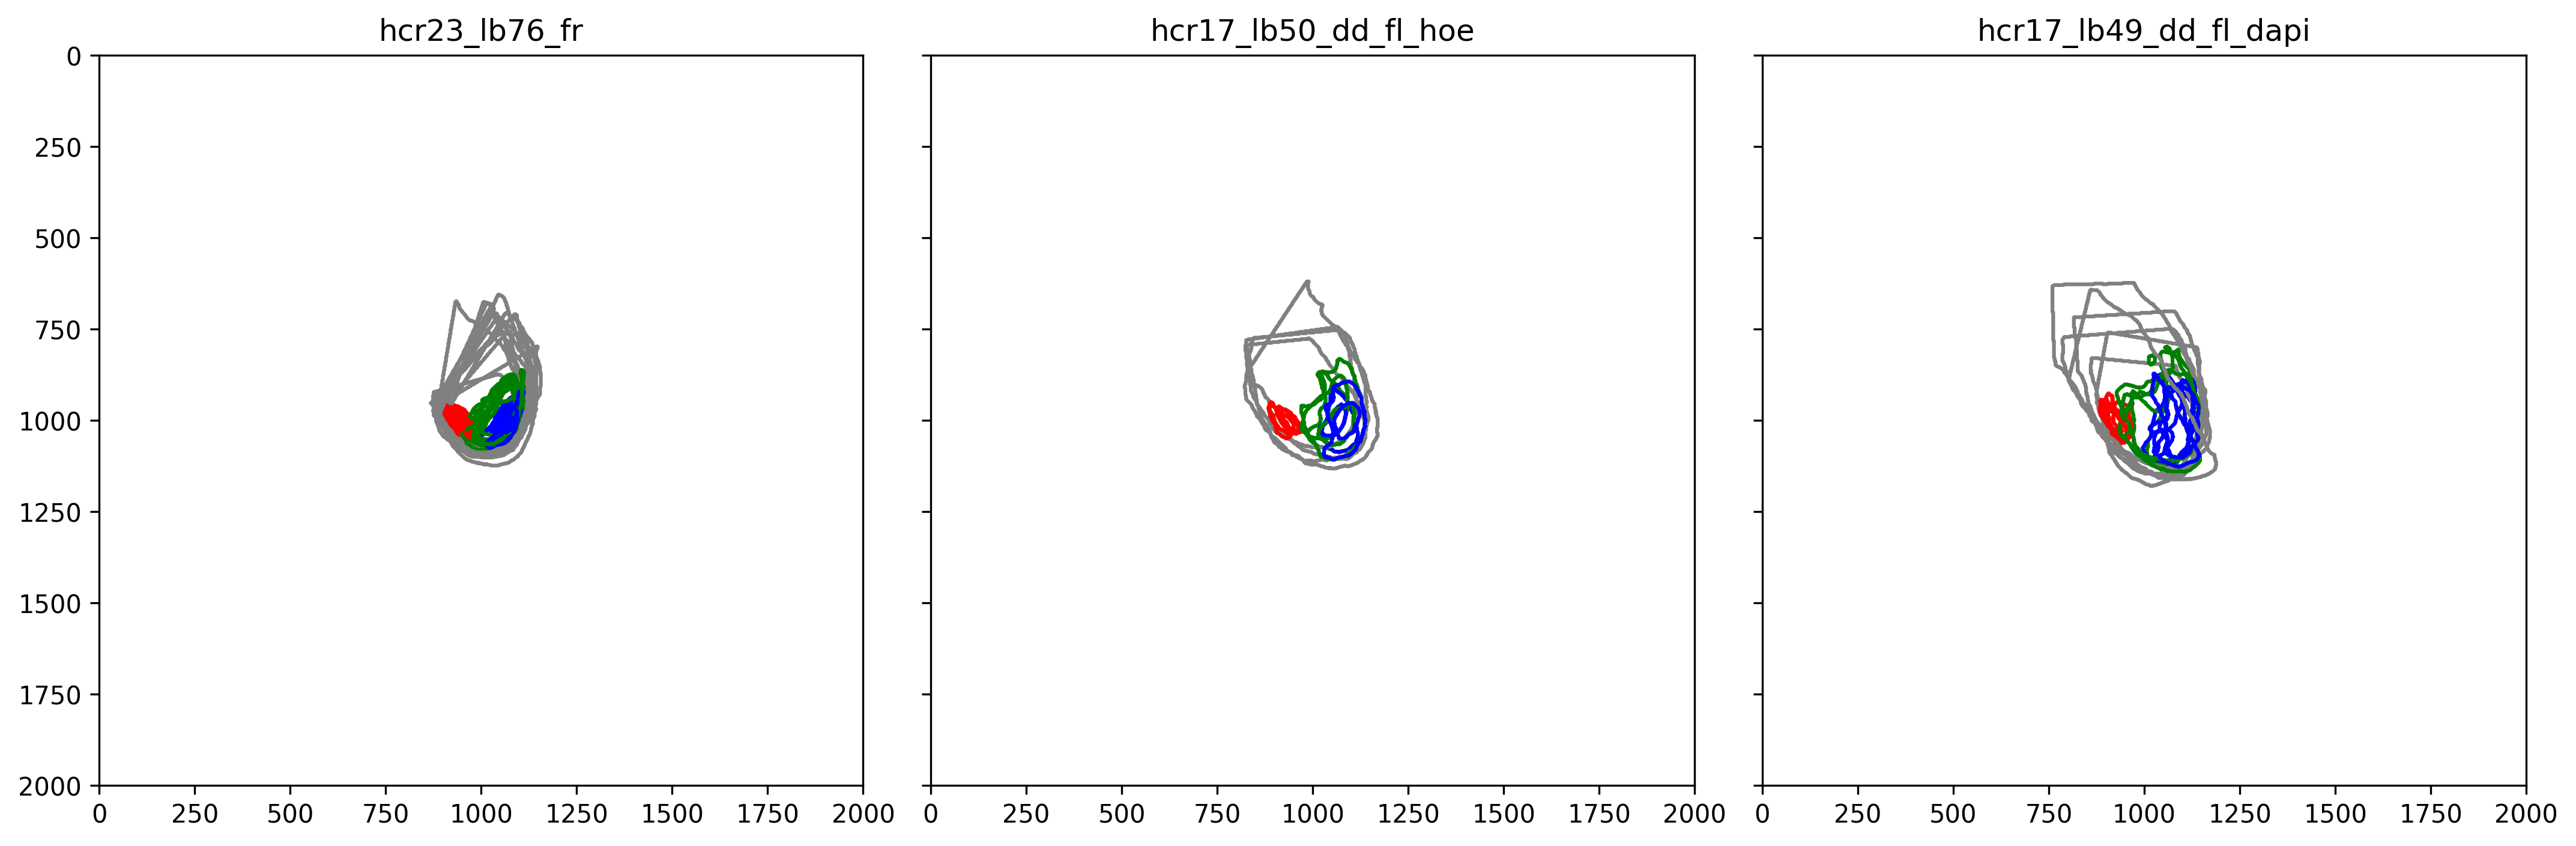

In [29]:
plot.overlay_n(img, pixel_size, size, 'shh_mask', 'dusp_mask', 'fgf_mask', 300)
plt.savefig('fig/limb_buds_overlay_grouped_by_proxi_for_PD_length.pdf')
plt.show()